In [29]:
import rasterio
from rasterio.plot import show
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt

In [30]:
path = "data/landsat9_rgb.tif"
ds = rasterio.open(path)

In [31]:
print("CRS:", ds.crs)
print("Bounds:", ds.bounds)
print("Número de bandas:", ds.count)
print("Dimensões (linhas, colunas):", ds.height, ds.width)
print("Índices disponíveis:", ds.indexes)    # ex.: [1, 2, 3]

CRS: EPSG:32720
Bounds: BoundingBox(left=395530.0, bottom=9021540.0, right=416130.0, top=9041630.0)
Número de bandas: 3
Dimensões (linhas, colunas): 2009 2060
Índices disponíveis: (1, 2, 3)


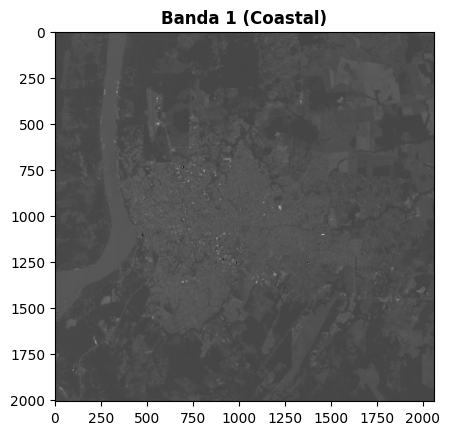

<Axes: title={'center': 'Banda 1 (Coastal)'}>

In [32]:
show(ds.read(1), cmap="gray", title="Banda 1 (Coastal)")

Criar uma composição colorida rápida

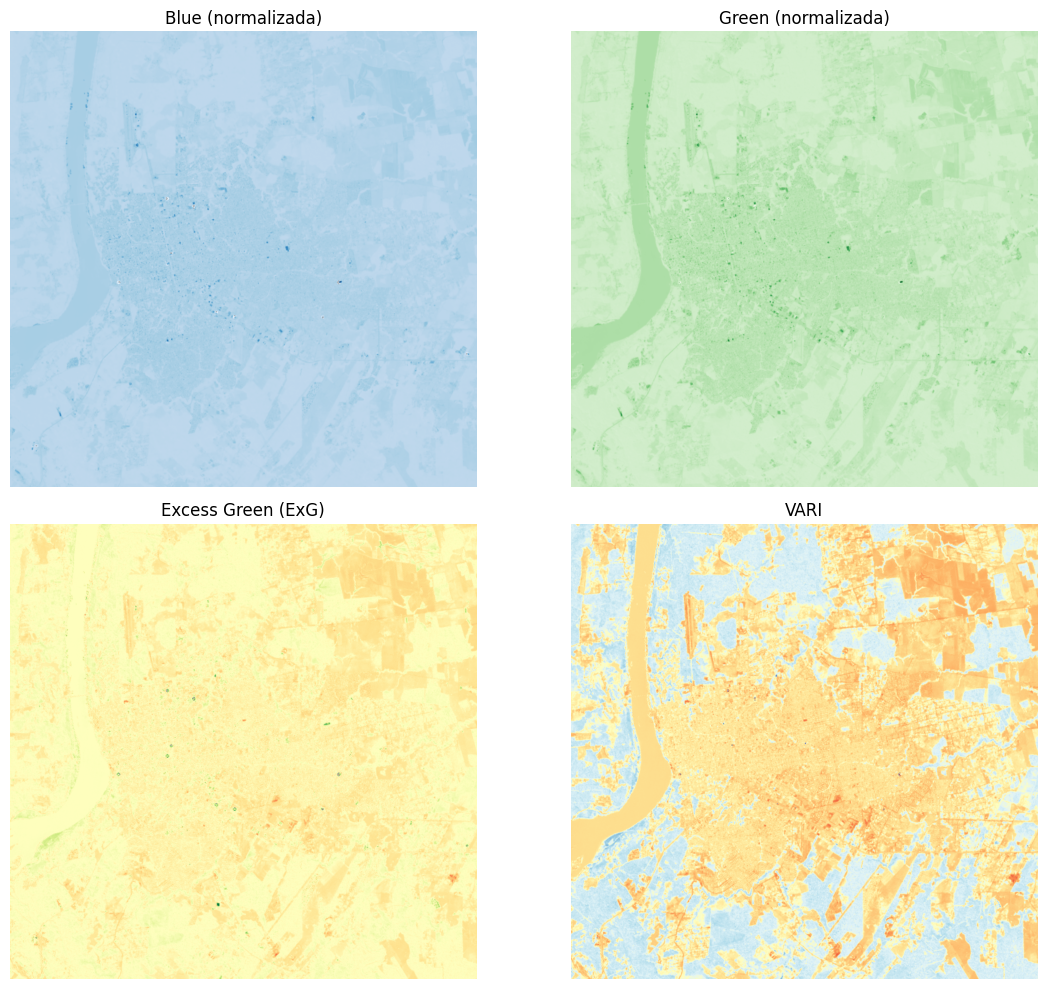

In [33]:
with rasterio.open(path) as ds:
    # Lembre de converter para float32 para evitar overflow
    b2 = ds.read(1).astype("float32")  # Blue
    b3 = ds.read(2).astype("float32")  # Green
    b4 = ds.read(3).astype("float32")  # Red

# --- 2) Converter DN → Surface Reflectance ---
# Para L2 SR do Landsat, normalmente:
#   reflectance = DN * 0.0000275 + (-0.2)
# Ajuste esses valores se seu metadata apontar outros fatores!
scale = 0.0000275
offset = -0.2

b2 = b2 * scale + offset
b3 = b3 * scale + offset
b4 = b4 * scale + offset

# --- 3) Normalizar [0,1] para cada banda ---
def normalize(arr):
    arr_min, arr_max = np.nanmin(arr), np.nanmax(arr)
    return (arr - arr_min) / (arr_max - arr_min)

nb2 = normalize(b2)
nb3 = normalize(b3)
nb4 = normalize(b4)

# --- 4) Calcular índices visuais ---
# 4.1 Excess Green (ExG) = 2*G - R - B
exg = 2 * nb3 - nb4 - nb2

# 4.2 VARI = (G - R) / (G + R - B)
vari = (nb3 - nb4) / (nb3 + nb4 - nb2 + 1e-6)  # evita divisão por zero

# --- 5) Visualizar resultados ---
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

axs[0].imshow(nb2, cmap="Blues")
axs[0].set_title("Blue (normalizada)")
axs[1].imshow(nb3, cmap="Greens")
axs[1].set_title("Green (normalizada)")
axs[2].imshow(exg, cmap="RdYlGn")
axs[2].set_title("Excess Green (ExG)")
axs[3].imshow(vari, cmap="RdYlBu")
axs[3].set_title("VARI")

for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()


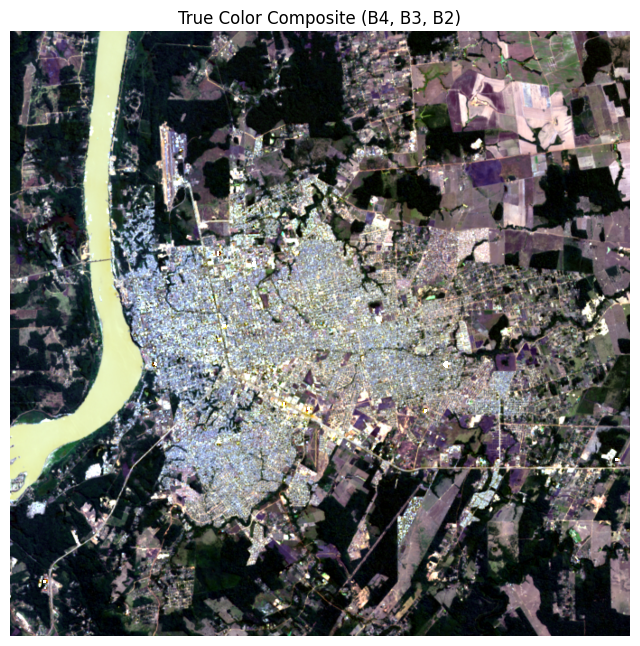

/tmp/ipykernel_2967/2893688096.py:36: RuntimeWarning: invalid value encountered in cast
  rgb_uint8 = (rgb * 255).astype("uint8")


In [36]:
with rasterio.open("data/landsat9_rgb.tif") as ds:
    red = ds.read(3).astype("float32")
    green = ds.read(2).astype("float32")
    blue = ds.read(1).astype("float32")

# Se ainda não aplicou escala SR → [0,1], use:
scale = 0.0000275
offset = -0.2

for arr in (red, green, blue):
    arr[:] = arr * scale + offset

# --- 2) Função de stretching por percentil 2–98% ---
def contrast_stretch(band):
    p2, p98 = np.nanpercentile(band, (2, 98))
    band = np.clip(band, p2, p98)
    return (band - p2) / (p98 - p2)

r = contrast_stretch(red)
g = contrast_stretch(green)
b = contrast_stretch(blue)

# --- 3) Empilhar canais em RGB ---
rgb = np.dstack([r, g, b])

# --- 4) Exibir e salvar ---
plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.title("True Color Composite (B4, B3, B2)")
plt.axis("off")
plt.show()

# Para salvar em arquivo:
import imageio
# converte para uint8 [0,255]
rgb_uint8 = (rgb * 255).astype("uint8")
imageio.imwrite("true_color_pvh.png", rgb_uint8)